In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, recall_score,f1_score,balanced_accuracy_score,accuracy_score
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import KFold
import warnings
import itertools
import seaborn as sns
warnings.filterwarnings('ignore')

Helper Functions

In [ ]:
def split_mouse_idx(values, proportions):
    if sum(proportions) != 1:
        raise ValueError("Proportions must sum to 1")

    # Shuffle the list to ensure random distribution
    random.shuffle(values)

    # Calculate the indices for splitting
    split_indices = [int(len(values) * sum(proportions[:i])) for i in range(1, len(proportions))]

    # Split the list according to the calculated indices
    splits = [values[i:j] for i, j in zip([0] + split_indices, split_indices + [None])]

    return splits[0],splits[1],splits[2]

def split_dataset(dataset, train_idx, val_idx, test_idx, column='mouse_idx'):
    train_set = dataset[dataset[column].isin(train_idx)]
    val_set = dataset[dataset[column].isin(val_idx)]
    test_set = dataset[dataset[column].isin(test_idx)]
    return train_set, val_set, test_set


def majority_voting_evaluation(model, val_df,fold_index=0):
    try:
        unique_mouse_ids = val_df['mouse_idx'].unique()
        y_true = []
        y_pred = []
        stat_df = pd.DataFrame(columns=['mouse_idx', 'probabilities', 'true_label', 'samples_count','fold_index'])
        for mouse_id in unique_mouse_ids:
            subset = val_df[val_df['mouse_idx'] == mouse_id]
            X_val = subset.iloc[:,:-2]
            true_label = subset['pup_gen'].iloc[0]  # Assuming all samples for a mouse_id have the same label
            y_true.append(true_label)

            predictions = model.predict(X_val.values).astype(int)
            predictions_proba = model.predict_proba(X_val.values)
            new_stat_row = {'mouse_idx':mouse_id,'probabilities':np.mean(predictions_proba, axis=0)[1],'true_label':true_label,'samples_count':len(predictions_proba),'fold_index':fold_index}
            stat_df = pd.concat([stat_df, pd.DataFrame([new_stat_row])], ignore_index=True)

            '''
            plt.figure(figsize=(10, 6))
            for class_index in range(2):
                plt.hist(predictions_proba[:, class_index], bins=50, alpha=0.5, label=f'Class {class_index}')

            plt.title('Histogram of Predicted Probabilities for Each Class')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)
            plt.show()
            '''


            # Calculate mean probabilities for each label
            mean_probabilities = np.mean(predictions_proba, axis=0)

            #print("Mean probability for each class:")
            #for i, mean_prob in enumerate(mean_probabilities):
            #    print(f"Class {i}: {mean_prob:.4f}")
            majority_vote = np.bincount(predictions).argmax()
            #print(str(mouse_id)+' '+ str(true_label) +' #N of predicted smaples: ' + str(len(predictions)) + ' Prob ' + str(np.mean(predictions)))
            if mean_probabilities[0]>=0.5:
               majority_vote=0
            else:
                majority_vote=1
            y_pred.append(majority_vote)

        # Calculate accuracy
        correct_predictions = sum([1 for true, pred in zip(y_true, y_pred) if true == pred])
        accuracy = correct_predictions / len(y_true)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)

        # Calculate Unweighted Average Recall (UAR)
        uar = recall_score(y_true, y_pred, average='macro')
    except Exception as inst:
            print(type(inst))
            print(inst.args)
            print(inst)

    return accuracy,uar, conf_matrix,y_true,y_pred,stat_df

def run_train_and_test(model,df,train_mouse_ids,val_mouse_ids):
    train_set, _, val_set = split_dataset(df, train_mouse_ids, [], val_mouse_ids)

    X_train = train_set.iloc[:,:-2]
    y_train = train_set['pup_gen']
    model.fit(X_train, y_train)

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model.fit(X_train, y_train,sample_weight=sample_weights)

    accuracy, uar ,_ ,y_true,y_pred,stat_df=  majority_voting_evaluation(model, val_set)
    return y_true,y_pred,stat_df

def get_train_val_test_dataset(dataset , prop=0.7):
    mouse_idx_propotion = prop
    unique_mouse_ids = dataset['mouse_idx'].unique()
    random.shuffle(unique_mouse_ids)
    train_validation_ids = unique_mouse_ids[:int(len(unique_mouse_ids)*mouse_idx_propotion)]
    test_ids = unique_mouse_ids[int(len(unique_mouse_ids)*mouse_idx_propotion):]
    train_validation_dataset = dataset[dataset['mouse_idx'].isin(train_validation_ids)]
    test_dataset = dataset[dataset['mouse_idx'].isin(test_ids)]
    return train_validation_dataset,test_dataset,train_validation_ids,test_ids



def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix', cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)

    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = f'{c}\n{p:.1f}%'
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = f'{c}\n{p:.1f}%'

    annot = np.array(annot)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, xticklabels=class_names, yticklabels=class_names, cbar=False)

    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, recall_score,roc_curve
import random
from dataclasses import dataclass, field
from typing import List, Tuple, Any, Dict

@dataclass
class FoldResults:
    accuracies: List[float] = field(default_factory=list)
    uar_scores: List[float] = field(default_factory=list)
    y_preds: List[Any] = field(default_factory=list)
    y_preds_proba: List[Any] = field(default_factory=list)
    y_trues: List[Any] = field(default_factory=list)
    aggregated_stats_df: pd.DataFrame = field(default_factory=lambda: pd.DataFrame(columns=['mouse_idx', 'probabilities', 'true_label', 'samples_count','fold_index']))
    conf_matrix: np.ndarray = field(default_factory=lambda: np.array([]))
    uar_all_folds: float = 0.0
    n_estimators: int = 0
    optimized_threshold : float = 0.0

@dataclass
class KFoldResults:
    validation: FoldResults = field(default_factory=FoldResults)
    training: FoldResults = field(default_factory=FoldResults)

def k_fold_cross_validation(df: pd.DataFrame, k: int, model: Any, target_column: str, id_column: str, split_function: Any, evaluation_function: Any,num_estimators:int) -> KFoldResults:
    unique_ids = df[id_column].unique()
    random.shuffle(unique_ids)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    results = KFoldResults()

    for fold, (train_idx, val_idx) in enumerate(kf.split(unique_ids), start=1):
        train_ids = unique_ids[train_idx]
        val_ids = unique_ids[val_idx]
        train_set, _, val_set = split_function(df, train_ids, [], val_ids)

        X_train = train_set.iloc[:,:-2]
        y_train = train_set[target_column]
        X_val = val_set.iloc[:,:-2]
        y_val = val_set[target_column]

        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        model.fit(X_train, y_train, sample_weight=sample_weights)

        # Evaluate on the training set
        accuracy_train, uar_train, _, y_true_train, y_pred_train, stat_df_train = evaluation_function(model, train_set,fold)
        results.training.y_trues.extend(y_true_train)
        #results.training.y_preds.extend(y_pred_train)
        results.training.aggregated_stats_df = pd.concat([results.training.aggregated_stats_df, stat_df_train], ignore_index=True)
        results.training.n_estimators = num_estimators



        # Evaluate on the validation set
        accuracy_val, uar_val, _, y_true_val, y_pred_val, stat_df_val = evaluation_function(model, val_set,fold)
        results.validation.y_trues.extend(y_true_val)
        #results.validation.y_preds.extend(y_pred_val)
        results.validation.aggregated_stats_df = pd.concat([results.validation.aggregated_stats_df, stat_df_val], ignore_index=True)
        results.validation.n_estimators = num_estimators

        optimal_th = get_optimal_threshold_from_training(results.training,fold)
        results.training.optimized_threshold = optimal_th
        results.validation.optimized_threshold = optimal_th

        k_fold_train_filtered = results.training.aggregated_stats_df[results.training.aggregated_stats_df['fold_index']==fold]
        y_train_pred_proba  = k_fold_train_filtered['probabilities'].values
        k_fold_val_filtered = results.validation.aggregated_stats_df[results.validation.aggregated_stats_df['fold_index']==fold]
        y_val_pred_proba  = k_fold_val_filtered['probabilities'].values

        y_train_pred_optimized = (y_train_pred_proba >= 0.5).astype(int)
        y_val_pred_optimized = (y_val_pred_proba >= 0.5).astype(int)

        results.training.y_preds.extend(y_train_pred_optimized)
        results.validation.y_preds.extend(y_val_pred_optimized)

        #print(f"Fold {fold}: Validation Accuracy = {accuracy_val}, Validation UAR = {uar_val}")
        #print(f"Fold {fold}: Training Accuracy = {accuracy_train}, Training UAR = {uar_train}")

    # Calculate confusion matrix for validation

    results.validation.conf_matrix = confusion_matrix(results.validation.y_trues, results.validation.y_preds)
    results.validation.uar_all_folds = accuracy_score(results.validation.y_trues, results.validation.y_preds)

    # Calculate confusion matrix for training
    results.training.conf_matrix = confusion_matrix(results.training.y_trues, results.training.y_preds)
    results.training.uar_all_folds = accuracy_score(results.training.y_trues, results.training.y_preds)

    print(f"Est {num_estimators}:  Training Accuraccy = {results.training.uar_all_folds}")
    print(f"Est {num_estimators}:  Validation Accuraccy = {results.validation.uar_all_folds}")
    print('*******************')

    return results

def get_optimal_threshold_from_training(k_fold_train,fold):
    k_fold_train_filtered = k_fold_train.aggregated_stats_df[k_fold_train.aggregated_stats_df['fold_index']==fold]
    y_train = k_fold_train_filtered['true_label'].values
    y_train_prob = k_fold_train_filtered['probabilities'].values
    # Calculate ROC curve on the training set
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)

    # Find the optimal threshold on the training set
    optimal_idx_train = np.argmax(tpr_train - fpr_train)
    optimal_threshold_train = thresholds_train[optimal_idx_train]
    return optimal_threshold_train


In [ ]:
col_names = ['syll1_s_freq','syll2_s_freq','syll3_s_freq','syll4_s_freq','syll5_s_freq','syll6_s_freq','syll7_s_freq','syll8_s_freq','syll9_s_freq','syll10_s_freq',
            'syll1_e_freq','syll2_e_freq','syll3_e_freq','syll4_e_freq','syll5_e_freq','syll6_e_freq','syll7_e_freq','syll8_e_freq','syll9_e_freq','syll10_e_freq',
            'syll1_dist','syll2_dist','syll3_dist','syll4_dist','syll5_dist','syll6_dist','syll7_dist','syll8_dist','syll9_dist','syll10_dist',
            'syll1_dur','syll2_dur','syll3_dur','syll4_dur','syll5_dur','syll6_dur','syll7_dur','syll8_dur','syll9_dur','syll10_dur',
             'mother_gen',
             'pup_sex',
             'avg_ISI_time','pup_age','session','pup_strain',
             'pup_gen',
             'mouse_idx'
]


# load data from xls/csv file
seed=25
propotion=0.7
k_fold=5
dataset = pd.read_csv("processed_data_for_final_classification_REDUCTION_BY_RECORDING_ALLDATA.csv", header=None, names=col_names)
train_validation_dataset,test_dataset,train_validation_ids,test_ids = get_train_val_test_dataset(dataset,propotion)

In [ ]:
from tqdm import tqdm
k_fold_results_per_estimators = []
for n_estimators in tqdm(range(5,300,25)):
    model = XGBClassifier(n_estimators=n_estimators, random_state=seed, learning_rate=0.01, max_depth=7, objective='binary:logistic', booster='gbtree',
reg_lambda = 1.5, reg_alpha = 0.05, min_child_weight = 0.1, scale_pos_weight = 0.8, colsample_bytree = 0.6)
    k_fold_results = k_fold_cross_validation(train_validation_dataset,k_fold,model, target_column='pup_gen', id_column='mouse_idx', split_function=split_dataset, evaluation_function=majority_voting_evaluation,num_estimators=n_estimators)
    k_fold_results_per_estimators.append(k_fold_results)

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:01<00:14,  1.34s/it]

Est 5:  Training Accuraccy = 0.3333333333333333
Est 5:  Validation Accuraccy = 0.3333333333333333
*******************


 17%|█▋        | 2/12 [00:02<00:14,  1.50s/it]

Est 30:  Training Accuraccy = 0.6979166666666666
Est 30:  Validation Accuraccy = 0.6458333333333334
*******************


 25%|██▌       | 3/12 [00:05<00:15,  1.77s/it]

Est 55:  Training Accuraccy = 0.8385416666666666
Est 55:  Validation Accuraccy = 0.6875
*******************


 33%|███▎      | 4/12 [00:07<00:15,  1.96s/it]

Est 80:  Training Accuraccy = 0.9010416666666666
Est 80:  Validation Accuraccy = 0.6875
*******************


 42%|████▏     | 5/12 [00:09<00:15,  2.21s/it]

Est 105:  Training Accuraccy = 0.8802083333333334
Est 105:  Validation Accuraccy = 0.625
*******************


 50%|█████     | 6/12 [00:13<00:16,  2.79s/it]

Est 130:  Training Accuraccy = 0.90625
Est 130:  Validation Accuraccy = 0.625
*******************


 58%|█████▊    | 7/12 [00:17<00:15,  3.15s/it]

Est 155:  Training Accuraccy = 0.9166666666666666
Est 155:  Validation Accuraccy = 0.6666666666666666
*******************


 67%|██████▋   | 8/12 [00:21<00:13,  3.47s/it]

Est 180:  Training Accuraccy = 0.890625
Est 180:  Validation Accuraccy = 0.7083333333333334
*******************


 75%|███████▌  | 9/12 [00:26<00:11,  3.80s/it]

Est 205:  Training Accuraccy = 0.9479166666666666
Est 205:  Validation Accuraccy = 0.7291666666666666
*******************


 83%|████████▎ | 10/12 [00:31<00:08,  4.21s/it]

Est 230:  Training Accuraccy = 0.9479166666666666
Est 230:  Validation Accuraccy = 0.7291666666666666
*******************


 92%|█████████▏| 11/12 [00:36<00:04,  4.52s/it]

Est 255:  Training Accuraccy = 0.9270833333333334
Est 255:  Validation Accuraccy = 0.6458333333333334
*******************


100%|██████████| 12/12 [00:42<00:00,  3.54s/it]

Est 280:  Training Accuraccy = 0.9427083333333334
Est 280:  Validation Accuraccy = 0.7291666666666666
*******************


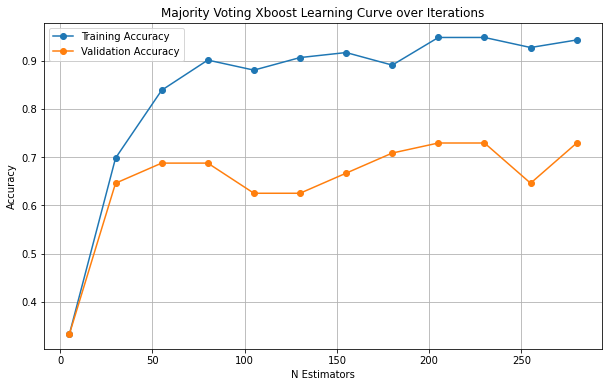

In [ ]:
import matplotlib.pyplot as plt
# Initialize lists to store the UAR values for training and validation
uar_train_all = []
uar_val_all = []
iterations_all = []

# Extract data from k_fold_results_per_estimators
for k_fold_result in k_fold_results_per_estimators:
    uar_train = k_fold_result.training.uar_all_folds
    uar_val = k_fold_result.validation.uar_all_folds
    iterations = k_fold_result.training.n_estimators

    uar_train_all.append(uar_train)
    uar_val_all.append(uar_val)
    iterations_all.append(iterations)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(iterations_all, uar_train_all, label='Training Accuracy', marker='o')
plt.plot(iterations_all, uar_val_all, label='Validation Accuracy', marker='o')

plt.xlabel('N Estimators')
plt.ylabel('Accuracy')
plt.title('Majority Voting Xboost Learning Curve over Iterations')
plt.legend()
plt.grid(True)
plt.show()

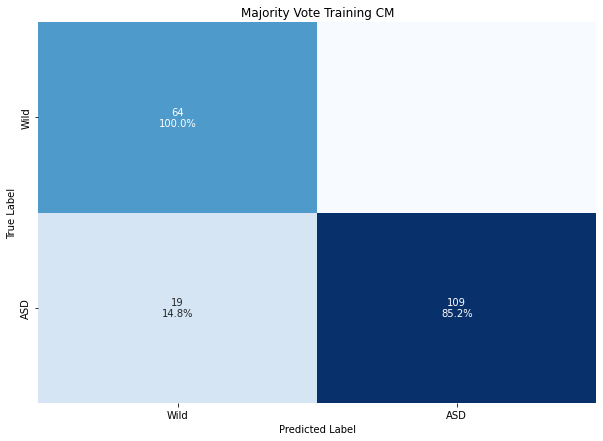

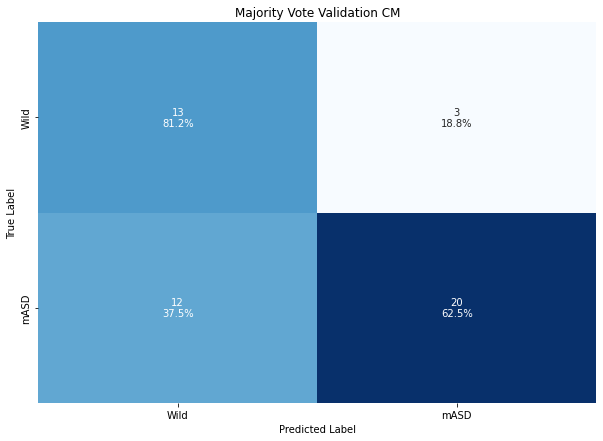

In [ ]:
index = 3
plot_confusion_matrix(k_fold_results_per_estimators[index].training.y_trues,k_fold_results_per_estimators[index].training.y_preds,['Wild','ASD'],title='Majority Vote Training CM')
plot_confusion_matrix(k_fold_results_per_estimators[index].validation.y_trues,k_fold_results_per_estimators[index].validation.y_preds,['Wild','mASD'],title='Majority Vote Validation CM')

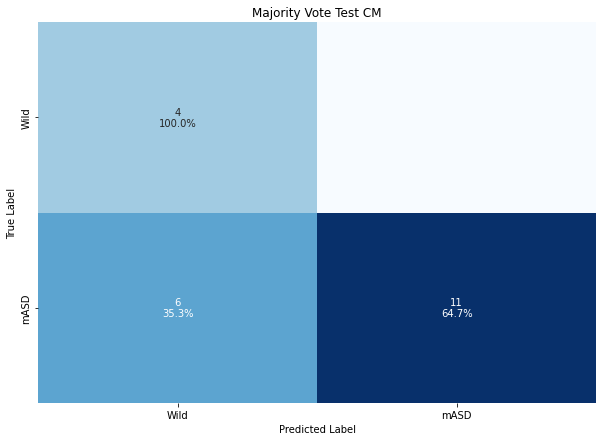

0.7142857142857143

In [ ]:
n_estimators = k_fold_results_per_estimators[index].validation.n_estimators
model = XGBClassifier(n_estimators=n_estimators, random_state=seed, learning_rate=0.01, max_depth=7, objective='binary:logistic', booster='gbtree',
reg_lambda = 1.5, reg_alpha = 0.05, min_child_weight = 0.1, scale_pos_weight = 0.8, colsample_bytree = 0.6)

y_true,y_pred,stat_df = run_train_and_test(model,dataset,train_validation_ids,test_ids)
conf_matrix_test = confusion_matrix(y_true, y_pred)
acc_test = accuracy_score(y_true, y_pred)
plot_confusion_matrix(y_true,y_pred,['Wild','mASD'],title='Majority Vote Test CM')
acc_test
